In [1]:
import torch
import HodgkinHuxley
import matplotlib.pyplot as plt
import numpy as np
import functions as func
import time

 
 << defining template for one-compartment sPY cell >> 
 
 
<< sPY: passive, INa, IK, IM inserted >>
 
	Vector[0] 


In [2]:
import sys
print("Python version")
print (sys.version)

print("Version info.")
print (sys.version_info)

Python version
3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Version info.
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


In [3]:
import os

print(os.getcwd())

seed_data = 7

/home/samuel/Documents/projects/seq posterior approx w nf/seq posterior approx w nf dev/hodgkin_huxley


## Gen sbi data

In [4]:
model = HodgkinHuxley.HodgkinHuxley("snl")

In [5]:
t_vec = np.array(HodgkinHuxley.h.t_vec)

In [6]:
v_true, Iinj = model.simulator(model.log_theta_true, seed_data, True)


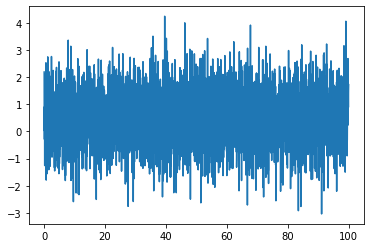

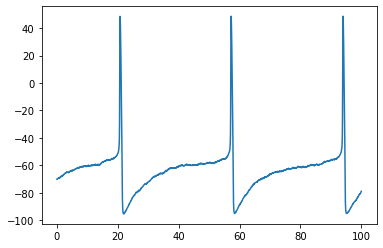

In [7]:

plt.figure()
plt.plot(t_vec, Iinj)

plt.figure()
plt.plot(t_vec, v_true)


In [8]:
summary_stats_obs = model.calculate_summary_statistics(v_true)


In [9]:
summary_stats_obs

array([-6.40828856e+01,  2.81086579e+00,  2.79212967e+00,  1.17168804e+02,
        4.67103817e+03,  3.00037889e+00,  6.60806063e+00,  1.03037433e+01,
        3.99239771e+03,  3.80963892e+03,  3.75168188e+03,  3.66387183e+03,
        3.57566284e+03,  3.48756299e+03,  3.40273657e+03,  3.32262183e+03,
        3.25609912e+03,  3.11782129e+03])

#### set up model simulator

In [10]:
def simulator_wrapper(params):

    # return tensor
    return model.calculate_summary_statistics(model.simulator(params))


In [11]:
# run pilot to calc mean and std of summary stats
whiteness_params = func.pilot_run(model, simulator_wrapper, summary_stats_obs)


Pilot run: running 2000 simulations: 100%|██████████| 2000/2000 [00:30<00:00, 64.84it/s]


In [12]:
summary_stats_obs_w = func.whiten(summary_stats_obs, whiteness_params)


In [13]:
#m_prior, std_prior = func.load_summary_stats_mean_and_std()


In [14]:
w_sim_wrapper = lambda param: torch.as_tensor(func.whiten(simulator_wrapper(param), whiteness_params))

#### run inference using SNL

In [15]:
from sbi.inference import SNLE_A, prepare_for_sbi

simulator, prior = prepare_for_sbi(w_sim_wrapper, model.prior)

In [16]:
def build_custom_lik_net(batch_theta, batch_x):

    flow_lik, flow_post = func.set_up_networks(model.prior.base_dist.low,
                                               model.prior.base_dist.high)

    return flow_lik

In [17]:
a = 1
b = 2

flow_like = build_custom_lik_net(a,b)



tensor([-2.5702, -1.7965,  1.6719, -1.7965, -2.1833, -1.9843,  1.8710, -3.4684,
        -1.8982,  0.3869])
tensor([0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581,
        0.5581])


In [18]:
s_temp = flow_like.sample(10)

In [19]:
s_temp.shape


torch.Size([10, 18])

In [20]:
s = torch.from_numpy(summary_stats_obs_w).to(dtype=torch.float32).reshape(1,18)
s_temp = flow_like.sample(10, context=s)


# why is this samping the same values???


RuntimeError: size mismatch, m1: [10 x 18], m2: [10 x 10] at /opt/conda/conda-bld/pytorch_1591914794252/work/aten/src/TH/generic/THTensorMath.cpp:41

In [ ]:
s_temp

In [21]:
print(summary_stats_obs)

print(summary_stats_obs_w)

[-6.40828856e+01  2.81086579e+00  2.79212967e+00  1.17168804e+02
  4.67103817e+03  3.00037889e+00  6.60806063e+00  1.03037433e+01
  3.99239771e+03  3.80963892e+03  3.75168188e+03  3.66387183e+03
  3.57566284e+03  3.48756299e+03  3.40273657e+03  3.32262183e+03
  3.25609912e+03  3.11782129e+03]
[-0.21000326 -0.78070888  0.09312562 -0.03140713 -0.11434297 -0.02393785
 -0.2751532   0.00828448 -0.09875204 -0.55145742  0.27009299  0.20448364
 -0.25240411  0.14666263 -1.33761857 -0.67148318  1.22850749 -0.7184205 ]


In [22]:
inference = SNLE_A(simulator, prior, density_estimator=build_custom_lik_net)

In [23]:
start = time.time()

torch.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import math

num_rounds = 5
x_o = torch.from_numpy(summary_stats_obs_w).to(dtype=torch.float32).reshape(1,18)

posteriors = []
proposal = None

for i in range(num_rounds):
    #lr = 0.001*math.exp(-0.95 * i)
    posterior = inference(num_simulations=1000, proposal=proposal, max_num_epochs=100) #, learning_rate=lr)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)


end = time.time()
run_time = end - start

print("")
print("Runtime:" + str(round(run_time, 2)))


tensor([-2.5702, -1.7965,  1.6719, -1.7965, -2.1833, -1.9843,  1.8710, -3.4684,
        -1.8982,  0.3869])
tensor([0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581, 0.5581,
        0.5581])


Generating samples:  22%|██▏       | 215/1000 [11:03<40:21,  3.08s/it]  


KeyboardInterrupt: 

In [ ]:
samples1 = posteriors[0].sample((2000,), x=x_o)
samples2 = posteriors[1].sample((2000,), x=x_o)
samples3 = posteriors[2].sample((2000,), x=x_o)
samples4 = posteriors[3].sample((2000,), x=x_o)
samples5 = posteriors[4].sample((2000,), x=x_o)

In [ ]:
prior_limits = []

for i in range(10):
    prior_limits.append([round(model.prior.base_dist.low[i].item(),1),
                         round(model.prior.base_dist.high[i].item(),1)])


In [ ]:
labels = ["log(gbar_Na)",
          "log(gbar_K)",
          "log(g_leak)",
          "log(E_Na)",
          "log(-E_K)",
          "log(-E_leak)",
          "log(gbar_M)",
          "log(tau_max)",
          "log(Vt)",
           "log(sigma)"]

In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples1,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples2,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)


In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples3,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples4,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

In [ ]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples5,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)